In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from algorithm import DualSMASignal

default_data = pd.read_csv("Datasets/SPY_raw.csv",
                           index_col="Date", parse_dates=True)

default_new_data = pd.read_csv("Datasets/SPY_input.csv",)


class AlgoTrader():

    def __init__(self, window=5, data=default_data):
        self.algorithm = None
        self.model = None
        self.window = window
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.default_data = data
        self.default_test = []
        self.past_close = None
        self.books = pd.DataFrame(
            columns=["Date", "Action", "Price", "Quantity"])
        self.cash = 1000000

    def load_lstm_model(self, model_path="RNN Trading/Algo Trading/model.keras"):
        try:
            self.model = load_model(model_path)
            print("Model loaded")

        except:
            print("Model not found")
            self.train_LSTM()

    def load_algorithm(self, algorithm):
        self.algorithm = algorithm

    def load_training_data(self, startdate=datetime.datetime(1993, 1, 1),
                           enddate=datetime.datetime(2023, 1, 1), ticker="SPY"):

        GetData = yf.download(ticker, start=startdate, end=enddate)
        df = pd.DataFrame(GetData)
        df.index = df.index.strftime('%Y-%m-%d')
        df = df.sort_index()

        # Build Columns
        df = df.assign(
            SMA_5=df['Close'].rolling(5).mean(),
            SMA_20=df['Close'].rolling(20).mean(),
            SMA_50=df['Close'].rolling(50).mean(),
            SMA_252=df['Close'].rolling(252).mean(),
            daily_return=(df['Close'].pct_change() * 100).round(2),
            monthly_return=(df['Close'].pct_change(30) * 100).round(2),
            adv20=df["Volume"].rolling(20).mean(),
            VWAP=(df['Volume'] * df['Close']).cumsum() / df['Volume'].cumsum()
        )
        # Add in log returns
        df['log_returns'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

        # add in monthly volatility
        df['volatility_30'] = df['log_returns'].rolling(30).std() * np.sqrt(30)
        df['volatility_60'] = df['log_returns'].rolling(60).std() * np.sqrt(60)
        df['annual_volatility'] = df['log_returns'].rolling(
            252).std() * np.sqrt(252)

        # add in change in monthly vriation rapp
        df["rapp"] = df["Close"].shift(-21).divide(df["Close"])
        df.dropna(inplace=True)

        self.default_data = df

    def train_LSTM(self, window=5, n_splits=5):

        # if self.model is not None:
        #    print("Model already trained")
        #    return

        def model_lstm(window, features):
            model = Sequential()
            model.add(LSTM(128, return_sequences=True,
                           input_shape=(window, features)))
            model.add(LSTM(64, return_sequences=False))
            model.add(Dense(30))
            model.add(Dense(1))
            model.compile(loss='mse', optimizer='adam')

            return model

        # Create a dataset of only the close column
        df = self.default_data['Close']
        dataset = df.values.reshape(-1, 1)

        # Scale dataset
        scaled_data = self.scaler.fit_transform(dataset)

        train, test = scaled_data[0:int(
            len(dataset) * 0.7), :], scaled_data[int(len(dataset) * 0.7):, :]

        train_x, train_y = self.reconstruct_data(train, 5)
        test_x, test_y = self.reconstruct_data(test, 5)
        self.default_test = [test_x, test_y]

        tscv = TimeSeriesSplit(n_splits=n_splits)

        epochs = [50]  # [50, 100]
        batch_sizes = [12]  # [12, 24]
        results = {
            "epoch": [],
            "batch_size": [],
            "score": []
        }
        for batch_size in batch_sizes:
            for epoch in epochs:
                score_tracking = []
                for train_index, val_index in tscv.split(train):

                    model = model_lstm(window, 1)
                    train_data, val_data = train[:max(
                        train_index)], train[max(train_index):]

                    train_data_x, train_data_y = self.reconstruct_data(
                        train_data, 5)
                    val_data_x, val_data_y = self.reconstruct_data(val_data, 5)
                    # print(train_data_x.shape, train_data_y.shape)

                    train_data_x = np.reshape(
                        train_data_x, (train_data_x.shape[0], train_data_x.shape[1], 1))
                    val_data_x = np.reshape(
                        val_data_x, (val_data_x.shape[0], val_data_x.shape[1], 1))

                    model.fit(train_data_x, train_data_y, epochs=epoch, batch_size=batch_size,
                              validation_data=(val_data_x, val_data_y),
                              verbose=0, callbacks=[], shuffle=False)

                    test_loss = model.evaluate(test_x, test_y)
                    score_tracking.append(test_loss)

                Mean_Squared_Error = np.mean(score_tracking)
                # Append to dataframe
                results["epoch"].append(epoch)
                results["batch_size"].append(batch_size)
                results["score"].append(Mean_Squared_Error)

        # Get Best Params individual
        print(results)
        params = pd.DataFrame(results).sort_values(
            by=['score'], ascending=True, ignore_index=True)
        #print(params.head(10))

        # Constructing Final Model using best params
        model = model_lstm(window, 1)
        train_x = np.reshape(train_x, (train_x.shape[0],  train_x.shape[1], 1))
        test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
        model.fit(
            train_x, train_y, epochs=int(params.iloc[0, 0]), batch_size=int(params.iloc[0, 1]), verbose=2)

        self.model = model
        model.save("RNN Trading/Algo Trading/model.keras")

        # Predicting Testing Dataset
        # Predicting Testing Dataset
        test_predict = model.predict(test_x)

        # print(test_predict.shape)
        predictions = self.scaler.inverse_transform(test_predict)
        test_y_real = self.scaler.inverse_transform(test_y.reshape(-1, 1))

        # Create dataset of actual close price and predicted close price
        final_df = pd.DataFrame({'Actual Close Price': test_y_real.flatten(
        ), 'Predicted Close Price': predictions.flatten()})
        # print(final_df)

        final_df.index = self.default_data[int(
            len(self.default_data) * 0.7)+5: -1].index

        self.past_close = final_df
        self.default_test = [test_x, test_y]
        # print(self.past_close)

    def reconstruct_data(self, data, n=1):
        data = pd.DataFrame(data)
        x, y = [], []
        for i in range(len(data) - n - 1):
            x.append(data.iloc[i:(i + n), :])
            # append close price
            y.append(data.iloc[i + n, 0])

        return (np.array(x), np.array(y))

    def reaggregate_data(self):
        # Build Columns
        df = self.default_data
        df = df.astype({"Close": float})
        df = df.assign(
            SMA_5=df['Close'].rolling(5).mean(),
            SMA_20=df['Close'].rolling(20).mean(),
            SMA_50=df['Close'].rolling(50).mean(),
            SMA_252=df['Close'].rolling(252).mean(),
            daily_return=(df['Close'].pct_change() * 100).round(2),
            monthly_return=(df['Close'].pct_change(30) * 100).round(2),
            adv20=df["Volume"].rolling(20).mean(),
            VWAP=(df['Volume'] * df['Close']).cumsum() / df['Volume'].cumsum()
        )
        # Add in log returns
        #print(df.info())
        df['log_returns'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

        # add in monthly volatility
        df['volatility_30'] = df['log_returns'].rolling(30).std() * np.sqrt(30)
        df['volatility_60'] = df['log_returns'].rolling(60).std() * np.sqrt(60)
        df['annual_volatility'] = df['log_returns'].rolling(
            252).std() * np.sqrt(252)

        # add in change in monthly vriation rapp
        df["rapp"] = df["Close"].shift(-21).divide(df["Close"])
        # df.dropna(inplace=True)

        self.default_data = df

    def load_visualisations(self):
        test_x = self.default_test[0]
        test_y = self.default_test[1]

        # Predicting Testing Dataset
        test_predict = self.model.predict(test_x)
        # print(test_x.shape)
        # print(test_predict)
        # test_predict = scaler.inverse_transform(test_predict)
        # test_labels = scaler.inverse_transform(test_y)
        plt.figure(figsize=(30, 10))
        plt.plot(test_y, label="actual")
        plt.plot(test_predict, label="prediction")
        plt.legend(fontsize=20)
        plt.grid(axis="both")
        plt.title("Actual close price and pedicted one on test set", fontsize=25)
        plt.show()

    def add_new_row(self, row_data):
        row_data.index = row_data['Date']
        data_temp = pd.concat(
            [self.default_data, row_data.drop(columns=['Date'])], axis=0).iloc[1:, :]
        # data_temp.iloc[-1].index = row_data['Date']
        self.default_data = data_temp
        #print(data_temp)
        self.reaggregate_data()
        print("New row added")

    # Predict adds in rows and reaggregates data

    def predict(self, row_data):
        print("Predicting new row")
        # print(row_data)
        # row_data is a dataframe of one row
        self.add_new_row(row_data)
        data_temp = self.default_data
        # Create a dataset of only the close column

        df = data_temp['Close']
        dataset = df.values.reshape(-1, 1)

        # Scale dataset
        scaled_data = self.scaler.fit_transform(dataset)

        train, test = scaled_data[0:int(
            len(dataset) * 0.7), :], scaled_data[int(len(dataset) * 0.7):, :]

        # train_x, train_y = self.reconstruct_data(train, 5)
        test_x, test_y = self.reconstruct_data(test, 5)

        # Set new default_test_data
        self.default_test = [test_x, test_y]

        # Predict new data
        test_predict = self.scaler.inverse_transform(
            self.model.predict(test_x))
        #print(test_predict)
        return (test_predict[-1][0])

    def load_algorithm(self, algorithm):
        self.algorithm = algorithm

    def run_algorithm(self, input_data=default_new_data):

        df = default_data
        past_close = self.past_close
        books = self.books

        for i in range(len(input_data)):

            # Read row_data
            row_data = pd.DataFrame(input_data.iloc[i, :]).transpose()
            print(f"Row {i}: ")
            print(row_data)
            date = row_data.iloc[0, 0]
            close = row_data.iloc[0, 3]
            print(f"Date: {row_data.iloc[0, 0]}")
            print(f"Close Price: {row_data.iloc[0, 3]}")

            # Add predicted close price into default_data
            predicted_close = self.predict(row_data)
            print(pd.DataFrame(self.default_data.iloc[-1:, :]))
            signal = self.algorithm.generate_sma_signals(
                pd.DataFrame(self.default_data.iloc[-1:, :]))

            if predicted_close < past_close.iloc[-1, 1] and not signal[0]:
                # Buy stock
                print(
                    f"Buying SPY500 on {date}, buying at {close}")
                self.cash -= close
                new_row = pd.DataFrame(
                    {"Date": date, "Action": "Buy", "Price": close, "Quantity": 1}, index=[0])
                books = pd.concat([books, new_row], axis=0, ignore_index=True)

                print(f"Current holdings: {books}")

                # add to past_close
                new_row = pd.DataFrame(
                    {"Actual Close Price": close, "Predicted Close Price": predicted_close}, index=[0])
                past_close = pd.concat(
                    [past_close, new_row], axis=0, ignore_index=True)

            elif predicted_close > past_close.iloc[-1, 1] and signal[0]:
                # Sell stock
                print(
                    f"Selling SPY500 on {date}, selling at {close}")
                self.cash += close

                new_row = pd.DataFrame(
                    {"Date": date, "Action": "Sell", "Price": close, "Quantity": 1}, index=[0])
                books = pd.concat([books, new_row], axis=0, ignore_index=True)

                print(f"Current holdings: {books}")

                # add to past_close
                new_row = pd.DataFrame(
                    {"Actual Close Price": close, "Predicted Close Price": predicted_close}, index=[0])
                past_close = pd.concat(
                    [past_close, new_row], axis=0, ignore_index=True)

        self.books = books
        self.past_close = past_close

        print("Trading completed")
        print(f"Final holdings: {books}")

    def tally_books(self):
        books = self.books
        total_profit = 0
        for i in range(len(books)):
            if books.iloc[i, 1] == "Buy":
                total_profit -= books.iloc[i, 2]
            else:
                total_profit += books.iloc[i, 2]

        return total_profit

        # Calculate Sharpe Ratio


In [6]:
def load_training_data(ticker, startdate=datetime.datetime(1993, 1, 1),
                       enddate=datetime.datetime(2023, 1, 1)):

    GetData = yf.download(ticker, start=startdate, end=enddate)
    df = pd.DataFrame(GetData)
    df.index = df.index.strftime('%Y-%m-%d')
    df = df.sort_index()

    # Build Columns
    df = df.assign(
        SMA_5=df['Close'].rolling(5).mean(),
        SMA_20=df['Close'].rolling(20).mean(),
        SMA_50=df['Close'].rolling(50).mean(),
        SMA_252=df['Close'].rolling(252).mean(),
        daily_return=(df['Close'].pct_change() * 100).round(2),
        monthly_return=(df['Close'].pct_change(30) * 100).round(2),
        adv20=df["Volume"].rolling(20).mean(),
        VWAP=(df['Volume'] * df['Close']).cumsum() / df['Volume'].cumsum()
    )
    # Add in log returns
    df['log_returns'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

    # add in monthly volatility
    df['volatility_30'] = df['log_returns'].rolling(30).std() * np.sqrt(30)
    df['volatility_60'] = df['log_returns'].rolling(60).std() * np.sqrt(60)
    df['annual_volatility'] = df['log_returns'].rolling(
        252).std() * np.sqrt(252)

    # add in change in monthly vriation rapp
    df["rapp"] = df["Close"].shift(-21).divide(df["Close"])
    df.dropna(inplace=True)
    
    df.to_csv(f"{ticker}_30years.csv")


In [ ]:
def load_new_data(ticker, startdate=datetime.datetime(1993, 1, 1),
                       enddate=datetime.datetime(2023, 1, 1)):

    GetData = yf.download(ticker, start=startdate, end=enddate)
    df = pd.DataFrame(GetData)
    df.index = df.index.strftime('%Y-%m-%d')
    df = df.sort_index()

    # Build Columns
    df = df.assign(
        SMA_5=df['Close'].rolling(5).mean(),
        SMA_20=df['Close'].rolling(20).mean(),
        SMA_50=df['Close'].rolling(50).mean(),
        SMA_252=df['Close'].rolling(252).mean(),
        daily_return=(df['Close'].pct_change() * 100).round(2),
        monthly_return=(df['Close'].pct_change(30) * 100).round(2),
        adv20=df["Volume"].rolling(20).mean(),
        VWAP=(df['Volume'] * df['Close']).cumsum() / df['Volume'].cumsum()
    )
    # Add in log returns
    df['log_returns'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

    # add in monthly volatility
    df['volatility_30'] = df['log_returns'].rolling(30).std() * np.sqrt(30)
    df['volatility_60'] = df['log_returns'].rolling(60).std() * np.sqrt(60)
    df['annual_volatility'] = df['log_returns'].rolling(
        252).std() * np.sqrt(252)

    # add in change in monthly vriation rapp
    df["rapp"] = df["Close"].shift(-21).divide(df["Close"])
    df.dropna(inplace=True)

    df.to_csv(f"{ticker}_30years.csv")


In [7]:
load_training_data("AAPL")
load_training_data("GOOG")
load_training_data("MSFT")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [11]:
ticker = "MSFT"
GetData = yf.download(ticker, start=datetime.datetime(2023, 1, 1))
df = pd.DataFrame(GetData)
df.index = df.index.strftime('%Y-%m-%d')
df = df.sort_index()
df.to_csv(f"{ticker}_input.csv")

[*********************100%%**********************]  1 of 1 completed


In [54]:
#from algotrader import AlgoTrader
from algorithm import DualSMASignal


In [55]:
default_new_data = pd.read_csv("../Datasets/SPY_input.csv",)
new_row = pd.DataFrame(default_new_data.iloc[0, :]).transpose()
print(new_row)


         Date        Open        High         Low       Close  Adj Close  \
0  2023-01-03  384.369995  386.429993  377.829987  380.820007  377.96814   

     Volume  
0  74850700  


In [56]:
algotrader = AlgoTrader()
algotrader.load_training_data()
algotrader.train_LSTM()
#algotrader.load_visualisations()
algotrader.load_algorithm(DualSMASignal())


[*********************100%%**********************]  1 of 1 completed
68/68 [==============================] - 0s 4ms/step - loss: 0.1405
{'epoch': [50], 'batch_size': [12], 'score': [0.13139912039041518]}
Epoch 1/50
424/424 - 8s - loss: 3.3867e-04 - 8s/epoch - 19ms/step
Epoch 2/50
424/424 - 3s - loss: 2.8564e-05 - 3s/epoch - 8ms/step
Epoch 3/50
424/424 - 3s - loss: 3.3804e-05 - 3s/epoch - 8ms/step
Epoch 4/50
424/424 - 3s - loss: 3.2564e-05 - 3s/epoch - 7ms/step
Epoch 5/50
424/424 - 3s - loss: 3.2291e-05 - 3s/epoch - 7ms/step
Epoch 6/50
424/424 - 3s - loss: 2.7308e-05 - 3s/epoch - 8ms/step
Epoch 7/50
424/424 - 3s - loss: 3.1430e-05 - 3s/epoch - 8ms/step
Epoch 8/50
424/424 - 3s - loss: 2.6530e-05 - 3s/epoch - 8ms/step
Epoch 9/50
424/424 - 3s - loss: 2.6846e-05 - 3s/epoch - 7ms/step
Epoch 10/50
424/424 - 3s - loss: 2.2176e-05 - 3s/epoch - 8ms/step
Epoch 11/50
424/424 - 3s - loss: 2.0223e-05 - 3s/epoch - 7ms/step
Epoch 12/50
424/424 - 3s - loss: 2.0063e-05 - 3s/epoch - 7ms/step
Epoch 13/50

In [57]:
results = pd.DataFrame({'epoch': [50, 100, 50, 100], 'batch_size': [12, 12, 24, 24], 'score': [
    0.12342862859368324, 0.13631596714258193, 0.08687245175242424, 0.09705450758337975]}).sort_values(
    by=['score'], ascending=True, ignore_index=True)
    


In [58]:
results.head()

,epoch,batch_size,score
0,50,24,0.086872
1,100,24,0.097055
2,50,12,0.123429
3,100,12,0.136316


In [59]:
algotrader.run_algorithm(default_new_data)


Row 0: 
         Date        Open        High         Low       Close  Adj Close  \
0  2023-01-03  384.369995  386.429993  377.829987  380.820007  377.96814   

     Volume  
0  74850700  
Date: 2023-01-03
Close Price: 377.8299865722656
Predicting new row
New row added
68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-01-03  384.369995  386.429993  377.829987  380.820007  377.96814   

              Volume    SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                
2023-01-03  74850700  396.394  391.742502  379.147001  415.180676   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-03         -6.59            3.34  80421900.0  172.224483    -0.068156   

     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High    Low      Close   Adj Close    Volume  \
Date                                                                         
2023-01-04  383.179993  385.880005  380.0  383.76001  380.886139  85934100   

                 SMA_5      SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                       
2023-01-04  392.680005  392.380002  379.337801  414.888454          0.77   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-01-04            5.02  80363600.0  172.253152     0.007691   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-04       0.113551       0.149248           0.250688   NaN  
Generating SMA signals
                  Open        High    Low      Close  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]
C:\Users\yinki\AppData\Local\Temp\ipykernel_21532\3749058051.py:343: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  books = pd.concat([books, new_row], axis=0, ignore_index=True)


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close  Adj Close  \
Date                                                                   
2023-01-05  381.720001  381.839996  378.76001  379.380005  376.53891   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-01-05  76970500  389.374005  392.531502  379.566401  414.594644   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-05         -1.14            1.36  79036865.0  172.278292    -0.011479   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-05       0.111849       0.148715           0.250791   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open    High         Low       Close   Adj Close     Volume  \
Date                                                                            
2023-01-06  382.609985  389.25  379.410004  388.079987  385.173737  104189600   

              SMA_5   SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                 
2023-01-06  387.944  392.938  380.041801  414.314049          2.29   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-01-06            2.43  80832000.0  172.313714     0.022673   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-06        0.11347       0.150162           0.251571   NaN  
Generating SMA signals
                  Open    High         Low       Close   Adj Cl

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-09  390.369995  393.700012  387.670013  387.859985  384.955383   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-01-09  73978100  383.979999  393.231  380.5314  413.994922         -0.06   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-01-09            0.76  80298850.0  172.338851    -0.000567   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-09       0.112401       0.143498           0.250674   NaN  
Generating SMA signals
                  Open        High         Low     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
              Open        High         Low       Close   Adj Close    Volume  \
Date                                                                           
2023-01-10  387.25  390.649994  386.269989  390.579987  387.655029  65358100   

                 SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                     
2023-01-10  385.931995  394.053499  380.9324  413.681668           0.7   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-01-10            2.24  79641980.0  172.361371     0.006988   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-10       0.112296       0.143624           0.250771   NaN  
Generating SMA signals
              Open        High         Low       Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-11  392.230011  395.600006  391.380005  395.519989  392.558044   

              Volume      SMA_5      SMA_20   SMA_50     SMA_252  \
Date                                                               
2023-01-11  68881100  388.28399  394.094998  381.587  413.400596   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-11          1.26            4.09  76013245.0  172.385816     0.012569   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-11       0.112719       0.143717           0.251049   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open       High         Low       Close   Adj Close  \
Date                                                                    
2023-01-12  396.670013  398.48999  392.420013  396.959991  393.987244   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-01-12  90157700  391.799988  394.017497  382.382599  413.107818   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-12          0.36            2.04  75829135.0  172.417748     0.003634   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-12       0.110403       0.143234           0.250884   NaN  
Generating SMA signals
                  Open       High      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low  Close   Adj Close    Volume  \
Date                                                                          
2023-01-13  393.619995  399.100006  393.339996  398.5  395.515717  63903900   

                SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                    
2023-01-13  393.88399  394.186497  383.0204  412.837699          0.39   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-01-13            3.18  75429155.0  172.440495     0.003872   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-13       0.110137       0.143088           0.250789   NaN  
Generating SMA signals
                  Open        High         Low  Close   Adj 

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-17  398.480011  400.230011  397.059998  397.769989  394.791168   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-01-17  62677300  395.865991  394.150497  383.4164  412.577422   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-17         -0.18            3.45  73903295.0  172.462721    -0.001834   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-17       0.110036       0.142591           0.250713   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                 Open        High         Low      Close   Adj Close  \
Date                                                                   
2023-01-18  399.01001  400.119995  391.279999  391.48999  388.558228   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-01-18  99632300  396.047992  393.952496  383.704399  412.263493   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-01-18         -1.58            4.43  75459485.0  172.49719    -0.015914   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-18       0.108057       0.142382           0.250655   NaN  
Generating SMA signals
                 Open        High         Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-01-19  389.359985  391.079987  387.26001  388.640015  385.729584   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-01-19  86958900  394.671997  393.672498  384.013199  411.954723   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-19         -0.73            4.75  76082615.0  172.526825    -0.007306   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-19       0.107756       0.142314           0.250609   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-20  390.100006  396.040009  388.380005  395.880005  392.915344   

              Volume    SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                
2023-01-20  91806400  394.456  393.664998  384.674999  411.700795   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-20          1.86            5.19  76026810.0  172.559581     0.018458   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-20       0.108345       0.142277           0.250973   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-23  396.720001  402.649994  395.720001  400.630005  397.629791   

              Volume       SMA_5      SMA_20    SMA_50    SMA_252  \
Date                                                                
2023-01-23  84178800  394.882001  393.966998  385.4872  411.48512   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-23           1.2            5.44  77673590.0  172.589813     0.011927   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-23       0.108551       0.142213           0.251079   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-24  398.880005  401.149994  397.640015  400.200012  397.202972   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-01-24  59524900  395.368005  393.981999  386.3364  411.235676   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-01-24         -0.11            4.76  77628385.0  172.61115    -0.001074   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-24       0.108521       0.142177            0.25042   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-25  395.950012  400.700012  393.559998  400.350006  397.351868   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-01-25  84800300  397.140009  393.878499  387.2122  410.968453   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-25          0.04            7.01  78455320.0  172.641548     0.000375   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-25       0.106043       0.141013           0.250199   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low   Close   Adj Close    Volume  \
Date                                                                           
2023-01-26  403.130005  404.920013  400.029999  404.75  401.718933  72287400   

                 SMA_5    SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                   
2023-01-26  400.362006  393.9995  387.9878  410.707144           1.1   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-01-26            2.55  80542420.0  172.667958      0.01093   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-26       0.092436       0.139469           0.250373   NaN  
Generating SMA signals
                  Open        High         Low   Close   Adj

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-27  403.660004  408.160004  403.440002  405.679993  402.641937   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-01-27  68346200  402.322003  394.487999  388.9488  410.423096   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-27          0.23             1.8  80565650.0  172.692994     0.002295   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-27       0.092004       0.138341           0.249958   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-30  402.799988  405.130005  400.279999  400.589996  397.590057   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-01-30  74202000  402.314001  394.755998  389.6242  410.120398   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-30         -1.25            1.38  81660250.0  172.719621    -0.012626   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-30       0.092513       0.136936           0.250245   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-31  401.130005  406.529999  400.769989  406.480011  403.435974   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-01-31  86811800  403.570001  394.695999  390.3312  409.838652   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-01-31          1.47            2.01  78772505.0  172.751629     0.014596   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-01-31        0.09326       0.134404           0.250704   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-01  405.209991  413.670013  402.350006  410.799988  407.723602   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-02-01  101459200  405.659998  396.194998  391.1772  409.579287   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-01          1.06            3.88  80102930.0  172.789642     0.010572   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-01       0.093359       0.134678           0.250945   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-02  414.859985  418.309998  412.880005  416.779999  413.658813   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-02-02  101654500  408.065997  397.845998  392.2046  409.348414   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-02-02          1.46            5.72  80888950.0  172.82863     0.014452   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-02       0.094158       0.134754           0.251388   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-03  411.589996  416.970001  411.089996  412.350006  409.262024   

              Volume  SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                          
2023-02-03  94736800  409.4  399.494498  392.9658  409.089049         -1.06   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-02-03            4.12  81777265.0  172.864318    -0.010686   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-03       0.094936        0.13187           0.251513   NaN  
Generating SMA signals
                  Open        High         Low       Clos

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-06  409.790009  411.290009  408.100006  409.829987  406.760864   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-02-06  60295300  411.247998  400.581998  393.584999  408.820318   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-06         -0.61            3.86  79582550.0  172.886849     -0.00613   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-06       0.095104       0.131763           0.251574   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open       High         Low       Close  Adj Close  \
Date                                                                   
2023-02-07  408.869995  416.48999  407.570007  415.190002  412.08075   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-02-07  90990700  412.989996  401.948499  394.190399  408.609247   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-07          1.31            3.82  80433180.0  172.921479     0.012994   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-07       0.095056       0.131912            0.25123   NaN  
Generating SMA signals
                  Open       High         

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-08  413.130005  414.529999  409.929993  410.649994  407.574738   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-02-08  76227500  412.959998  402.951999  394.762999  408.381906   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-02-08         -1.09            2.05  80976650.0  172.95002    -0.010995   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-08       0.095678       0.132478            0.25145   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-09  414.410004  414.570007  405.809998  407.089996  404.041382   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-02-09  78694900  411.021997  403.530499  395.305199  408.147779   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-09         -0.87            1.18  81467340.0  172.979024    -0.008707   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-09       0.096135       0.130704            0.25156   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-02-10  405.859985  408.440002  405.01001  408.040009  404.984283   

              Volume       SMA_5    SMA_20      SMA_50     SMA_252  \
Date                                                                 
2023-02-10  70769700  410.159998  404.0845  395.685599  407.919723   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-10          0.23            3.06  80497940.0  173.005284     0.002331   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-10       0.094622       0.128242           0.251575   NaN  
Generating SMA signals
                  Open        High        Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-02-13  408.720001  412.970001  408.23999  412.829987  409.738403   

              Volume       SMA_5      SMA_20      SMA_50    SMA_252  \
Date                                                                  
2023-02-13  64913500  410.759998  404.800999  396.217999  407.69385   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-13          1.17            4.45  80548420.0  173.030188     0.011671   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-13       0.095169       0.126443           0.251688   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                 Open        High        Low       Close   Adj Close  \
Date                                                                   
2023-02-14  411.23999  415.049988  408.51001  412.640015  409.549866   

              Volume   SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                           
2023-02-14  88389300  410.25  405.544501  396.7804  407.462184         -0.05   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-02-14            1.22  81834020.0  173.063433     -0.00046   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-14       0.090126       0.126077           0.251668   NaN  
Generating SMA signals
                 Open        High        Low       Close   A

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-15  410.350006  414.059998  409.470001  413.980011  410.879822   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-02-15  61555700  410.916003  406.669002  397.5626  407.261588   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-15          0.32            8.71  79930190.0  173.086794     0.003242   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-15       0.055613        0.12576           0.251338   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-16  408.790009  412.910004  408.140015  408.279999  405.222473   

              Volume       SMA_5      SMA_20   SMA_50    SMA_252  \
Date                                                               
2023-02-16  76431500  411.154004  407.651001  398.308  407.03762   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-16         -1.38            6.39  79403820.0  173.115039    -0.013864   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-16        0.05778       0.126333           0.251694   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open       High         Low      Close   Adj Close  \
Date                                                                   
2023-02-17  406.059998  407.51001  404.049988  407.26001  404.210144   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-02-17  89257800  410.998004  408.220001  398.9262  406.842263   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-02-17         -0.25            7.35  79276390.0  173.14794    -0.002501   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-17       0.056281        0.12437           0.251098   NaN  
Generating SMA signals
                  Open       High         Low      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-21  403.059998  404.160004  398.820007  399.089996  396.101318   

              Volume       SMA_5      SMA_20   SMA_50     SMA_252  \
Date                                                                
2023-02-21  82655900  408.250006  408.143001  399.309  406.633295   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-21         -2.01            2.84  79200245.0  173.177294    -0.020265   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-21       0.056631       0.125738           0.251682   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-02-22  399.519989  401.130005  397.019989  398.540009  395.55542   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-02-22  83742300  405.430005  408.060001  399.6398  406.441985   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-02-22         -0.14            2.75  80411115.0  173.20689    -0.001379   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-22       0.056659       0.124828           0.251457   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High     Low       Close   Adj Close    Volume  \
Date                                                                           
2023-02-23  401.559998  402.200012  396.25  400.660004  397.659546  96242400   

                 SMA_5    SMA_20    SMA_50    SMA_252  daily_return  \
Date                                                                  
2023-02-23  402.766003  408.0755  400.1704  406.29389          0.53   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-02-23            2.58  80983220.0  173.241255     0.005305   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-23       0.056497       0.124638           0.250768   NaN  
Generating SMA signals
                  Open        High     Low       Close   Adj Cl

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open    High         Low       Close   Adj Close     Volume  \
Date                                                                            
2023-02-24  395.420013  397.25  393.640015  396.380005  393.411591  108194400   

                 SMA_5      SMA_20    SMA_50    SMA_252  daily_return  \
Date                                                                    
2023-02-24  400.386005  407.657001  400.2042  406.12143         -1.07   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-02-24            0.22  82778570.0  173.279134     -0.01074   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-24       0.056303       0.125024            0.25094   NaN  
Generating SMA signals
                  Open    High         Low       Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High     Low       Close   Adj Close    Volume  \
Date                                                                           
2023-02-27  399.869995  401.290009  396.75  397.730011  394.751495  80444700   

                 SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                     
2023-02-27  398.480005  407.259502  400.1886  405.975636          0.34   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-02-27            0.19  83383495.0  173.307497       0.0034   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-27       0.056288       0.122892           0.250685   NaN  
Generating SMA signals
                  Open        High     Low       Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low      Close  Adj Close  \
Date                                                                   
2023-02-28  397.230011  399.279999  396.149994  396.26001  393.29248   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-02-28  96438600  397.914008  407.043002  400.2114  405.828335   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-02-28         -0.37           -0.56  84495325.0  173.341303    -0.003703   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-02-28       0.056267       0.122719           0.250699   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low      Close   Adj Close  \
Date                                                                    
2023-03-01  395.410004  396.690002  393.380005  394.73999  391.783875   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-03-01  99706800  397.154004  406.456001  400.1364  405.683493   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-03-01         -0.38           -0.76  85140075.0  173.376103    -0.003843   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-01       0.056364       0.122699           0.250681   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-02  392.679993  398.690002  392.329987  397.809998  394.830872   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-03-02  85127800  396.584003  405.806502  400.1836  405.508334   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-03-02          0.78            1.61  84323505.0  173.406031     0.007747   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-02       0.054499       0.120046           0.249567   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-03  399.709991  404.450012  399.029999  404.190002  401.163086   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-03-03  90120000  398.146002  405.177002  400.3826  405.326906   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-03-03           1.6             4.0  83746780.0  173.438807     0.015911   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-03        0.05597       0.120395           0.249432   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close  Adj Close  \
Date                                                                   
2023-03-06  405.049988  407.450012  404.01001  404.470001  401.44104   

              Volume    SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-03-06  72795900  399.494  404.783002  400.5514  405.134525          0.07   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-03-06            2.17  82649735.0  173.465196     0.000693   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-06       0.053083       0.119683           0.249331   NaN  
Generating SMA signals
                  Open        High        Low       Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-07  404.420013  404.670013  397.630005  398.269989  395.287445   

               Volume       SMA_5      SMA_20   SMA_50    SMA_252  \
Date                                                                
2023-03-07  108310600  399.895996  404.205002  400.625  404.90008   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-03-07         -1.53           -0.59  85050500.0  173.503523    -0.015447   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-07        0.05415        0.12052           0.249573   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-08  398.390015  399.709991  396.589996  398.920013  395.932587   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-03-08  74746600  400.732001  403.391502  400.6054  404.710874   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-03-08          0.16           -0.32  84238295.0  173.530044     0.001631   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-08       0.054172       0.120433           0.248489   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                 Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-03-09  399.73999  401.480011  390.529999  391.559998  388.627686   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-03-09  111945300  399.482001  402.437003  400.3882  404.484128   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-03-09         -1.84            -2.2  86024185.0  173.568757    -0.018622   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-09       0.057242       0.120053           0.249098   NaN  
Generating SMA signals
                 Open        High         

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                 Open        High         Low       Close  Adj Close  \
Date                                                                   
2023-03-10  390.98999  393.160004  384.320007  385.910004  383.02002   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-03-10  189253000  395.826001  401.378003  400.0598  404.240676   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-03-10         -1.44           -4.65  91552090.0  173.63184    -0.014535   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-10       0.057534       0.108368           0.249477   NaN  
Generating SMA signals
                 Open        High         Low   

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-13  381.809998  390.390015  380.649994  385.359985  382.474091   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-03-13  157790000  392.003998  400.244002  399.8488  403.980437   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-03-13         -0.14           -5.01  95903105.0  173.684177    -0.001426   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-13       0.057395       0.107893           0.249322   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
             Open        High         Low       Close   Adj Close     Volume  \
Date                                                                           
2023-03-14  390.5  393.450012  387.049988  391.730011  388.796448  149752400   

                 SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                     
2023-03-14  390.696002  399.189003  399.7788  403.719287          1.65   

            monthly_return        adv20        VWAP  log_returns  \
Date                                                               
2023-03-14           -2.21  100145050.0  173.735351     0.016395   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-14       0.059001       0.108893           0.249443   NaN  
Generating SMA signals
             Open        High         Low       Clo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open       High         Low       Close   Adj Close  \
Date                                                                    
2023-03-15  385.890015  389.48999  383.709991  389.279999  386.364777   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-03-15  172996900  388.767999  398.021002  399.4108  403.481033   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-15         -0.63           -4.23  104375430.0  173.793669   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-15    -0.006274       0.057046       0.108704           0.248888   NaN  
Generating SMA signals
                  Open       High      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-16  386.820007  396.470001  386.290009  396.109985  393.143616   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-03-16  143254200  389.677997  397.127501  399.7166  403.305041   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-16          1.75           -3.58  108460355.0  173.843467   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-16     0.017393       0.058909        0.10988           0.248773   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low      Close   Adj Close  \
Date                                                                    
2023-03-17  393.220001  394.399994  388.549988  389.98999  388.546692   

               Volume       SMA_5   SMA_20      SMA_50     SMA_252  \
Date                                                                 
2023-03-17  140553400  390.493994  396.213  399.841199  403.110477   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-17         -1.55           -6.43  111666450.0  173.891204   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-17    -0.015571       0.058297       0.110945           0.249218   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low      Close   Adj Close  \
Date                                                                    
2023-03-20  390.799988  394.170013  390.070007  393.73999  392.282806   

              Volume       SMA_5   SMA_20      SMA_50     SMA_252  \
Date                                                                
2023-03-20  93055800  392.169995  395.537  400.128399  402.902699   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-20          0.96           -4.51  111856350.0  173.923229   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-20      0.00957       0.058769       0.111276           0.248874   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                 Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-03-21  397.23999  399.410004  395.579987  398.910004  397.433685   

              Volume       SMA_5   SMA_20      SMA_50     SMA_252  \
Date                                                                
2023-03-21  91524200  393.605994  395.528  400.344999  402.713453   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-21          1.31           -2.66  112299765.0  173.955468   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-21     0.013045       0.060327       0.111985           0.249238   NaN  
Generating SMA signals
                 Open        High         Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open       High         Low       Close   Adj Close  \
Date                                                                    
2023-03-22  398.730011  402.48999  392.070007  392.109985  390.658844   

               Volume       SMA_5      SMA_20      SMA_50    SMA_252  \
Date                                                                   
2023-03-22  111746600  394.171991  395.206499  400.429999  402.53508   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-22          -1.7           -5.56  113699980.0  173.993607   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-22    -0.017193       0.060687       0.112494           0.248901   NaN  
Generating SMA signals
                  Open       High   

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-23  395.089996  399.290009  390.350006  393.170013  391.714935   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-03-23  119351300  393.583997  394.831999  400.4818  402.372144   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-23          0.27           -4.26  114855425.0  174.034516   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-23       0.0027       0.060107       0.112337           0.248846   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low   Close Adj Close     Volume  \
Date                                                                          
2023-03-24  391.839996  395.839996  389.399994  395.75  394.2854  107682400   

                 SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                     
2023-03-24  394.735999  394.800499  400.4864  402.237937          0.66   

            monthly_return        adv20        VWAP  log_returns  \
Date                                                               
2023-03-24           -2.79  114829825.0  174.071873     0.006541   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-03-24       0.060137        0.11255           0.248723   NaN  
Generating SMA signals
                  Open        High         Low   Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low      Close   Adj Close  \
Date                                                                    
2023-03-27  398.119995  398.920013  395.559998  396.48999  395.022644   

              Volume       SMA_5      SMA_20   SMA_50     SMA_252  \
Date                                                                
2023-03-27  74010400  395.285999  394.738498  400.477  402.136905   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-27          0.19           -2.83  114508110.0  174.097664   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-27     0.001868       0.060113       0.111412           0.248105   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open       High         Low       Close   Adj Close  \
Date                                                                    
2023-03-28  395.769989  396.48999  393.690002  395.600006  394.135956   

              Volume       SMA_5      SMA_20   SMA_50     SMA_252  \
Date                                                                
2023-03-28  62871700  394.623999  394.705498  400.419  402.007144   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-28         -0.22           -4.17  112829765.0  174.119435   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-28    -0.002247       0.058682       0.111421           0.247644   NaN  
Generating SMA signals
                  Open       High         Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-29  399.929993  401.600006  398.679993  401.350006  399.864655   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-03-29  77497900  396.472003  395.035999  400.490601  401.862699   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-29          1.45           -2.74  111719320.0  174.146971   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-29      0.01443       0.060786       0.107908            0.24709   NaN  
Generating SMA signals
                  Open        Hig

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-03-30  404.089996  404.350006  401.76001  403.700012  402.205963   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-03-30  69840000  398.578003  395.330499  400.734801  401.732025   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-30          0.59           -2.48  110954930.0  174.172061   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-30     0.005838       0.061025       0.083074           0.247157   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-31  404.660004  409.700012  404.549988  409.390015  407.874908   

               Volume       SMA_5    SMA_20      SMA_50     SMA_252  \
Date                                                                  
2023-03-31  112062600  401.306006  395.5905  401.149801  401.650318   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-03-31          1.41            0.27  112052060.0  174.213255   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-03-31     0.013996       0.061232       0.083829           0.247107   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-03  408.850006  411.369995  408.440002  410.950012  409.429138   

              Volume      SMA_5    SMA_20      SMA_50     SMA_252  \
Date                                                                
2023-04-03  67391100  404.19801  395.9145  401.451201  401.543413   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-04-03          0.38            0.91  111781820.0  174.238194   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-04-03     0.003803       0.061281       0.082889           0.246447   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-04-04  411.619995  411.920013  407.23999  408.670013  407.157593   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-04  66601500  406.812012  396.434502  401.612001  401.436112   

            daily_return  monthly_return        adv20       VWAP  log_returns  \
Date                                                                            
2023-04-04         -0.55             2.4  109696365.0  174.26264    -0.005564   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-04       0.057844       0.080263           0.246459   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-05  407.910004  408.700012  405.880005  407.600006  406.091553   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-05  65200200  408.062012  396.868501  401.760001  401.338612   

            daily_return  monthly_return        adv20        VWAP  \
Date                                                                
2023-04-05         -0.26            2.27  109219045.0  174.286417   

            log_returns  volatility_30  volatility_60  annual_volatility  rapp  
Date                                                                            
2023-04-05    -0.002622       0.057906       0.080327           0.246343   NaN  
Generating SMA signals
                  Open        Hig

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-06  406.769989  409.480011  405.679993  409.190002  407.675659   

              Volume      SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                  
2023-04-06  63743300  409.16001  397.750002  401.936801  401.297977   

            daily_return  monthly_return        adv20      VWAP  log_returns  \
Date                                                                           
2023-04-06          0.39            2.13  106808945.0  174.3098     0.003893   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-06       0.057808       0.080145           0.244566   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-10  406.609985  409.690002  405.970001  409.609985  408.094086   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-10  63681000  409.204004  398.935001  402.034001  401.271628   

            daily_return  monthly_return        adv20       VWAP  log_returns  \
Date                                                                            
2023-04-10           0.1            3.34  100530345.0  174.33324     0.001026   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-10       0.056583       0.079244           0.244452   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 5ms/step
                 Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-04-11  410.26001  411.179993  408.920013  409.720001  408.203674   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-11  59297900  408.958002  400.153001  402.114801  401.201429   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-11          0.03            3.01  95605740.0  174.355131     0.000269   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-11       0.056538       0.079183           0.242998   NaN  
Generating SMA signals
                 Open        High      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-12  411.869995  412.170013  407.440002  408.049988  406.539856   

              Volume       SMA_5   SMA_20      SMA_50     SMA_252  \
Date                                                                
2023-04-12  86420400  408.833997  400.969  402.264001  401.132263   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-12         -0.41            2.98  92439140.0  174.386652    -0.004084   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-12       0.056572       0.079241            0.24299   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-04-13  409.179993  413.839996  407.98999  413.470001  411.939819   

              Volume       SMA_5    SMA_20      SMA_50     SMA_252  \
Date                                                                 
2023-04-13  85814800  410.007996  402.1785  402.403801  401.106072   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-13          1.33            4.74  88080035.0  174.418727     0.013195   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-13       0.057626       0.080231           0.243024   NaN  
Generating SMA signals
                  Open        High        Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-14  412.809998  415.089996  410.059998  412.459991  410.933533   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-14  78161500  410.661993  402.996001  402.437001  401.088056   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-14         -0.24            3.68  84825400.0  174.447837    -0.002446   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-14       0.057392       0.078516           0.242926   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-17  412.369995  413.959991  411.089996  413.940002  412.408081   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-17  66436400  411.527997  404.193501  402.380201  401.039524   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-04-17          0.36            2.41  81119550.0  174.47267     0.003582   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-17       0.055414       0.078117           0.241967   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 5ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-18  415.579987  415.720001  412.779999  414.209991  412.677063   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-18  63560000  412.425995  405.217001  402.417401  400.954564   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-18          0.07            2.41  79644760.0  174.496471     0.000652   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-18       0.055414       0.076085           0.240954   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-04-19  412.220001  415.079987  412.160004  414.140015  412.60733   

              Volume    SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                
2023-04-19  55227300  413.644  405.978502  402.503601  400.847699   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-19         -0.02            3.98  77829915.0  174.517153    -0.000169   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-19       0.052828       0.075235            0.24062   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-20  411.209991  413.700012  410.269989  411.880005  410.355713   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-20  75840400  413.326001  406.967003  402.437401  400.718175   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-20         -0.55            3.25  76034605.0  174.545283    -0.005472   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-20       0.053258        0.07546            0.24054   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-04-21  412.190002  412.679993  410.170013  412.200012  410.67453   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-21  73457400  413.274005  407.918503  402.468401  400.590437   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-21          0.08            5.27  73739910.0  174.572566     0.000777   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-21        0.04922       0.075461           0.240543   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                 Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-04-24  411.98999  413.070007  410.600006  412.630005  411.102936   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-24  64332100  413.012006  408.762503  402.579202  400.443771   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-24           0.1            6.92  71572395.0  174.596581     0.001043   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-24       0.046277       0.074713           0.240248   NaN  
Generating SMA signals
                 Open        High      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-25  410.579987  411.160004  406.019989  406.079987  404.577148   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-25  97766700  411.386005  409.242003  402.540001  400.294088   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-25         -1.59            5.38  72760210.0  174.631925    -0.016001   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-25       0.049642       0.076442           0.240428   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-26  406.720001  407.839996  403.779999  404.359985  402.863495   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-04-26  80447000  409.429999  409.680002  402.370601  400.111032   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-26         -0.42            3.22  73638975.0  174.660771    -0.004245   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-26        0.04759       0.075486           0.239966   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
             Open        High        Low       Close   Adj Close    Volume  \
Date                                                                         
2023-04-27  407.0  412.690002  406.73999  412.410004  410.883728  92968400   

                 SMA_5      SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                       
2023-04-27  409.535999  410.233002  402.366001  399.951191          1.99   

            monthly_return       adv20       VWAP  log_returns  volatility_30  \
Date                                                                            
2023-04-27            5.94  74412500.0  174.69523     0.019712       0.050457   

            volatility_60  annual_volatility  rapp  
Date                                                
2023-04-27       0.076645           0.240753   NaN  
Generating SMA signals
             Open        High        Low       Close   Ad

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                 Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-04-28  411.48999  415.940002  411.429993  415.929993  414.390686   

              Volume       SMA_5      SMA_20      SMA_50    SMA_252  \
Date                                                                  
2023-04-28  89335600  410.281995  410.844501  402.405001  399.79254   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-04-28          0.85             5.0  75387280.0  174.728882     0.008499   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-04-28       0.048377       0.076389           0.240801   NaN  
Generating SMA signals
                 Open        High         

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 2ms/step
                  Open        High         Low      Close  Adj Close  \
Date                                                                   
2023-05-01  415.470001  417.619995  415.269989  415.51001  413.97226   

              Volume       SMA_5    SMA_20      SMA_50     SMA_252  \
Date                                                                 
2023-05-01  62122300  410.857996  411.1505  402.549601  399.609842   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-01          -0.1            6.54  72890265.0  174.752308     -0.00101   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-01       0.045102       0.075009           0.240466   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-05-02  414.769989  414.820007  407.820007  410.839996  409.31955   

               Volume       SMA_5   SMA_20      SMA_50     SMA_252  \
Date                                                                 
2023-05-02  103998500  411.809998  411.145  402.621201  399.419921   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-02         -1.12            4.34  74720635.0  174.790586    -0.011303   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-02       0.046345         0.0751           0.240644   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-03  411.359985  413.869995  407.769989  408.019989  406.509979   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-05-03  91531800  412.541998  411.112498  402.7998  399.246826   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-03         -0.69            2.28  75967150.0  174.823831    -0.006888   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-03       0.045449       0.075166           0.240256   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-05-04  406.929993  407.269989  403.73999  405.130005  403.630676   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-05-04  94901900  411.085999  410.988998  402.9316  399.057183   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-04         -0.71            3.32  77452235.0  174.857862    -0.007108   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-04       0.042343       0.074295           0.240327   NaN  
Generating SMA signals
                  Open        High        Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-05  408.910004  413.720001  408.640015  412.630005  411.102936   

              Volume       SMA_5      SMA_20   SMA_50     SMA_252  \
Date                                                                
2023-05-05  87844000  410.426001  411.160999  403.171  398.881905   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-05          1.85            4.95  78657270.0  174.890388     0.018343   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-05       0.045714       0.075821           0.240894   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open       High         Low      Close   Adj Close  \
Date                                                                   
2023-05-08  412.970001  413.23999  411.279999  412.73999  411.212494   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-05-08  50046800  409.871997  411.317499  403.4982  398.729961   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-08          0.03            4.29  77975560.0  174.908911     0.000267   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-08       0.045444       0.075293           0.240578   NaN  
Generating SMA signals
                  Open       High         Low   

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-05-09  411.130005  412.089996  410.690002  410.929993  409.40921   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-05-09  49220100  409.889996  411.377998  403.7622  398.588731   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-09         -0.44            3.64  77471670.0  174.927087    -0.004395   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-09       0.045807       0.075402           0.240415   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-10  413.880005  414.540009  408.869995  412.850006  411.322113   

              Volume    SMA_5      SMA_20   SMA_50     SMA_252  daily_return  \
Date                                                                           
2023-05-10  96142900  410.856  411.617999  404.094  398.446191          0.47   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-05-10            4.36  77957795.0  174.962673     0.004661   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-10       0.045791       0.074632           0.240408   NaN  
Generating SMA signals
                  Open        High         Low       C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-11  411.950012  412.429993  409.970001  412.130005  410.604767   

              Volume    SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-05-11  70157100  412.256  411.550999  404.4418  398.305556         -0.17   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-05-11            2.69  77174910.0  174.988566    -0.001746   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-11       0.043854       0.074651             0.2404   NaN  
Generating SMA signals
                  Open        High         Low     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-12  413.420013  413.640015  409.070007  411.589996  410.066772   

              Volume       SMA_5    SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-05-12  70439400  412.047998  411.5075  404.7174  398.193135   

            daily_return  monthly_return       adv20      VWAP  log_returns  \
Date                                                                          
2023-05-12         -0.13            1.95  76788805.0  175.0145    -0.001311   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-12       0.043601       0.074587           0.239802   NaN  
Generating SMA signals
                  Open        High         Low       C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low      Close   Adj Close  \
Date                                                                    
2023-05-15  412.220001  413.429993  410.230011  413.01001  411.481506   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-05-15  54289400  412.102002  411.461  404.8938  398.092818          0.35   

            monthly_return       adv20      VWAP  log_returns  volatility_30  \
Date                                                                           
2023-05-15            0.88  76181455.0  175.0346     0.003444       0.041483   

            volatility_60  annual_volatility  rapp  
Date                                                
2023-05-15       0.073336           0.239806   NaN  
Generating SMA signals
                  Open        High         Low      Close   

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low   Close  Adj Close    Volume  \
Date                                                                         
2023-05-16  411.859985  412.820007  410.23999  410.25  408.73172  57705500   

                 SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                  
2023-05-16  411.966003  411.263  405.0094  397.961628         -0.67   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-05-16           -0.17  75888730.0  175.055713    -0.006705   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-16       0.041893       0.073613           0.239608   NaN  
Generating SMA signals
                  Open        High        Low   Close  Adj Close    V

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-17  412.350006  415.859985  410.640015  415.230011  413.693298   

              Volume       SMA_5    SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-05-17  87287000  412.442004  411.3175  405.3486  397.872104   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-17          1.21            1.61  77491715.0  175.088314     0.012066   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-17       0.043185       0.071579            0.23961   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-18  414.899994  419.670013  414.670013  419.230011  417.678497   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-05-18  97177200  413.862006  411.685001  405.7548  397.797739   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-05-18          0.96            2.85  78558555.0  175.12521     0.009587   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-18       0.043981         0.0721            0.23981   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-05-19  420.170013  420.720001  417.350006  418.619995  417.07074   

               Volume       SMA_5   SMA_20   SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-05-19  103679700  415.268005  412.006  406.296  397.692897         -0.15   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-05-19             2.3  80069670.0  175.164458    -0.001456   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-19       0.043935       0.071991           0.239262   NaN  
Generating SMA signals
                  Open        High         Low       C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-22  418.640015  420.390015  417.350006  418.790009  417.240143   

              Volume       SMA_5   SMA_20    SMA_50    SMA_252  daily_return  \
Date                                                                           
2023-05-22  60745400  416.424005  412.314  406.9536  397.59004          0.04   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-05-22            2.24  79890335.0  175.187456     0.000406   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-22       0.043935       0.071042           0.239262   NaN  
Generating SMA signals
                  Open        High         Low       C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-23  417.079987  418.720001  413.679993  414.089996  412.557526   

              Volume       SMA_5    SMA_20      SMA_50     SMA_252  \
Date                                                                 
2023-05-23  86383500  417.192004  412.7145  407.528201  397.494921   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-23         -1.12            1.07  79321175.0  175.219591    -0.011286   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-23       0.045553       0.072031           0.239057   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-24  412.420013  412.820007  409.880005  411.089996  409.568604   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-05-24  89213700  416.364001  413.051001  407.9154  397.435596   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-24         -0.72            0.75  79759510.0  175.252298    -0.007271   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-24       0.045984       0.072339           0.237553   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                 Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-05-25  414.73999  416.160004  412.410004  414.649994  413.115448   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-05-25  90961600  415.447998  413.163  408.4228  397.380596          0.87   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-05-25            0.29  79659170.0  175.286139     0.008623   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-25       0.044865       0.072631           0.237641   NaN  
Generating SMA signals
                 Open        High         Low       Cl

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 5ms/step
                  Open        High     Low       Close   Adj Close    Volume  \
Date                                                                           
2023-05-26  415.329987  420.769989  415.25  420.019989  418.465546  93830000   

                 SMA_5    SMA_20   SMA_50     SMA_252  daily_return  \
Date                                                                  
2023-05-26  415.727997  413.3675  408.901  397.396151           1.3   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-05-26            1.83  79883890.0  175.321847     0.012868   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-26        0.04655       0.073305            0.23617   NaN  
Generating SMA signals
                  Open        High     Low       Close   Adj Cl

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-05-30  422.029999  422.579987  418.73999  420.179993  418.624969   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-05-30  72216000  416.005994  413.600999  409.5048  397.407699   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-30          0.04            1.51  80388575.0  175.349484     0.000381   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-30       0.046448         0.0717           0.236154   NaN  
Generating SMA signals
                  Open        High        Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-31  418.279999  419.220001  416.220001  417.850006  416.303619   

               Volume       SMA_5    SMA_20      SMA_50     SMA_252  \
Date                                                                  
2023-05-31  110811800  416.757996  413.9515  409.987001  397.368175   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-05-31         -0.55            0.88  80729240.0  175.391264    -0.005561   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-05-31       0.046841       0.071968           0.234889   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-01  418.089996  422.920013  416.790009  421.820007  420.258911   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-06-01  88865000  418.903998  414.641501  410.445201  397.407143   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-01          0.95            1.85  80595900.0  175.425324     0.009456   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-01       0.047723       0.070638           0.232033   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
             Open       High         Low       Close   Adj Close    Volume  \
Date                                                                         
2023-06-02  424.5  428.73999  423.950012  427.920013  426.336334  91366700   

                 SMA_5      SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                       
2023-06-02  421.558002  415.781001  411.161401  397.460477          1.45   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-06-02            3.89  80419140.0  175.462213     0.014358   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-02       0.049205       0.071896           0.232397   NaN  
Generating SMA signals
             Open       High         Low       Close  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 5ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-05  428.279999  429.619995  426.369995  427.100006  425.519379   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-06-05  65460200  422.974005  416.504501  411.840001  397.503016   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-05         -0.19            3.61  79299950.0  175.487833    -0.001918   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-05       0.049307       0.069107           0.232363   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-06-06  426.670013  428.579987  425.98999  428.029999  426.445923   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-06-06  64022200  424.544006  417.269002  412.485601  397.498929   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-06          0.22            3.73  79998720.0  175.512971     0.002175   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-06       0.049316        0.06717           0.230426   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-07  428.440002  429.619995  426.109985  426.549988  424.971375   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-06-07  85373300  426.284003  418.050002  413.086801  397.549485   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-07         -0.35            5.04  81806380.0  175.546298    -0.003464   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-07       0.046288       0.067298           0.227573   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-06-08  426.619995  429.600006  425.820007  429.130005  427.54187   

              Volume       SMA_5      SMA_20      SMA_50    SMA_252  \
Date                                                                  
2023-06-08  61952800  427.746002  418.864001  413.757401  397.62008   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-08           0.6            6.13  80096875.0  175.570688      0.00603   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-08       0.046076       0.065776           0.227567   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open       High         Low       Close  Adj Close  \
Date                                                                   
2023-06-09  429.959991  431.98999  428.869995  429.899994  428.30899   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-06-09  85742800  428.141998  419.752501  414.328401  397.745993   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-09          0.18            4.24  80876160.0  175.604542     0.001793   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-09        0.04227       0.065297            0.22519   NaN  
Generating SMA signals
                  Open       High         

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2023-06-12  430.920013  433.880005  430.170013  433.799988  432.19455   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-06-12  76104300  429.481995  420.863  414.9304  397.883731          0.91   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-06-12             4.3  81159405.0  175.635025     0.009031   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-12       0.042366       0.063764            0.22535   NaN  
Generating SMA signals
                  Open        High         Low       C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-13  435.320007  437.329987  434.630005  436.660004  435.043976   

              Volume       SMA_5    SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-06-13  95899700  431.207996  422.0455  415.4758  398.057977   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-13          0.66            5.09  83239920.0  175.673865     0.006571   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-13       0.042597       0.061536           0.224837   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                 Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-06-14  437.01001  439.059998  433.589996  437.179993  435.562042   

               Volume       SMA_5   SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-06-14  100612100  433.333997  423.392  416.0004  398.235913   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-14          0.12            6.41  85385250.0  175.714676      0.00119   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-14       0.040443       0.061041           0.224833   NaN  
Generating SMA signals
                 Open        High         Low      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-15  436.329987  443.899994  436.230011  442.600006  440.962006   

               Volume       SMA_5    SMA_20   SMA_50     SMA_252  \
Date                                                               
2023-06-15  110303100  436.027997  424.7605  416.679  398.398135   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-15          1.24            8.48  86536055.0  175.760354     0.012321   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-15       0.040603       0.060908           0.223945   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-16  443.019989  443.609985  438.970001  439.459991  439.459991   

               Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                    
2023-06-16  114121300  437.939996  425.771999  417.316199  398.554365   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-16         -0.71            8.47  87383260.0  175.807096     -0.00712   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-16       0.040606       0.058511           0.224026   NaN  
Generating SMA signals
                  Open        Hig

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-20  437.450012  438.369995  435.029999  437.179993  437.179993   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-06-20  76160400  438.615997  426.699998  417.875999  398.668889   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-20         -0.52            5.95  86007295.0  175.838039    -0.005202   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-20        0.03797       0.058933           0.223193   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open       High         Low       Close   Adj Close  \
Date                                                                    
2023-06-21  436.160004  436.98999  434.329987  434.940002  434.940002   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-06-21  76982300  438.271997  427.507498  418.382599  398.839842   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-21         -0.51            5.38  86819140.0  175.868951    -0.005137   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-21       0.038594       0.059128           0.219356   NaN  
Generating SMA signals
                  Open       High      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low      Close  Adj Close  \
Date                                                                   
2023-06-22  433.950012  436.619995  433.600006  436.51001  436.51001   

              Volume    SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-06-22  70637200  438.138  428.628499  418.9184  399.026548          0.36   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-06-22            6.22  86031825.0  175.897486     0.003603   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-22       0.038103       0.059163            0.21928   NaN  
Generating SMA signals
                  Open        High         Low      Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-23  432.929993  435.059998  432.470001  433.209991  433.209991   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-06-23  92074500  436.259998  429.734499  419.4216  399.199485   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-23         -0.76            4.93  86174865.0  175.934304    -0.007589   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-23       0.039176       0.059754           0.219428   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-26  432.619995  434.609985  431.190002  431.440002  431.440002   

              Volume    SMA_5      SMA_20   SMA_50     SMA_252  daily_return  \
Date                                                                           
2023-06-26  72823600  434.656  430.573999  419.781  399.336469         -0.41   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-06-26            4.69  85267965.0  175.963158    -0.004094   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-26       0.039453       0.058541           0.218718   NaN  
Generating SMA signals
                  Open        High         Low       C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 5ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-27  432.350006  436.809998  431.880005  436.170013  436.170013   

              Volume       SMA_5    SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-06-27  72813700  434.454004  431.3815  420.2552  399.504246   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-06-27           1.1            5.97  84217150.0  175.992515     0.010904   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-27       0.040423       0.059165           0.218824   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-28  435.049988  437.440002  434.410004  436.390015  436.390015   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-06-28  75636000  434.744006  432.192001  420.7042  399.659088   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-06-28          0.05            5.66  84388150.0  176.02304     0.000504   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-28       0.040417       0.057739           0.218662   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-29  435.959991  438.279999  435.540009  438.109985  438.109985   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-06-29  67882300  435.064001  433.205  421.1822  399.789246          0.39   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-06-29            6.79  82241675.0  176.050609     0.003934   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-29        0.03948       0.057745           0.217822   NaN  
Generating SMA signals
                  Open        High         Low     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-30  441.440002  444.299988  441.109985  443.279999  443.279999   

               Volume       SMA_5   SMA_20   SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-06-30  104921500  437.078003  434.278  421.765  399.900437          1.18   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-06-30            6.76  83044500.0  176.094108     0.011732   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-06-30       0.039395       0.058313           0.216798   NaN  
Generating SMA signals
                  Open        High         Low     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-03  442.920013  444.079987  442.630005  443.790009  443.790009   

              Volume       SMA_5    SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-07-03  32793400  439.548004  435.0715  422.4032  400.022897   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-03          0.12            5.86  80115835.0  176.107713      0.00115   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-03        0.03865       0.058173           0.216719   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-05  441.910004  443.890015  441.899994  443.130005  443.130005   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-07-05  58418400  440.940002  435.873  423.0218  400.155993         -0.15   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-05            5.85  79763745.0  176.132023    -0.001488   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-05       0.038653       0.058189           0.216562   NaN  
Generating SMA signals
                  Open        High         Low     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-06  439.420013  440.100006  437.059998  439.660004  439.660004   

              Volume    SMA_5    SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                          
2023-07-06  80658300  441.594  436.4545  423.5624  400.244366         -0.78   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-06            4.98  80595550.0  176.165009    -0.007861   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-06       0.039849       0.058911           0.215912   NaN  
Generating SMA signals
                  Open        High         Low       Clos

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-07  438.630005  442.640015  438.299988  438.549988  438.549988   

              Volume       SMA_5    SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-07-07  86076100  441.682001  437.0545  424.2118  400.355516   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-07         -0.25            5.91  80630690.0  176.200053    -0.002528   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-07       0.037825       0.059021           0.215274   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-10  438.179993  439.839996  437.589996  439.660004  439.660004   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-07-10  62443500  440.958002  437.581  424.9178  400.466111          0.25   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-10            6.95  80655225.0  176.225608     0.002528   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-10       0.036614       0.058796           0.215268   NaN  
Generating SMA signals
                  Open        High         Low     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-11  440.450012  442.970001  439.440002  442.459991  442.459991   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-07-11  64463800  440.691998  438.209  425.5188  400.572143          0.64   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-11            6.71  79591275.0  176.252187     0.006348   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-11       0.036272       0.057771           0.215153   NaN  
Generating SMA signals
                  Open        High         Low     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-12  446.390015  447.480011  444.910004  446.019989  446.019989   

              Volume       SMA_5  SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                           
2023-07-12  91924500  441.269995  438.82  426.1206  400.710238           0.8   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-12            6.19  80382285.0  176.290592     0.008014   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-12       0.035096       0.058059           0.214999   NaN  
Generating SMA signals
                  Open        High         Low       C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-13  447.899994  450.380005  447.450012  449.559998  449.559998   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-07-13  72425200  443.249994  439.464999  426.8016  400.901191   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-07-13          0.79            6.99  79208560.0  176.32123     0.007906   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-13       0.035541       0.058391           0.213731   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-07-14  450.480011  451.359985  448.48999  449.279999  449.279999   

              Volume       SMA_5  SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                           
2023-07-14  69761800  445.395996  440.07  427.5704  401.137223         -0.06   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-14            7.52  77666045.0  176.350743    -0.000623   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-14       0.034752       0.058421           0.211619   NaN  
Generating SMA signals
                  Open        High        Low       Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-17  449.130005  451.929993  449.079987  450.839996  450.839996   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-07-17  52680200  447.631995  440.481999  428.4268  401.438175   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-17          0.35            6.88  74784900.0  176.373125     0.003466   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-17       0.034005       0.058438           0.207932   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
             Open        High         Low       Close   Adj Close    Volume  \
Date                                                                          
2023-07-18  450.5  454.859985  450.049988  454.190002  454.190002  80744400   

                 SMA_5    SMA_20   SMA_50     SMA_252  daily_return  \
Date                                                                  
2023-07-18  449.977997  441.2185  429.408  401.756905          0.74   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-18            6.14  73116055.0  176.407977     0.007403   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-18       0.032094       0.058313           0.208004   NaN  
Generating SMA signals
             Open        High         Low       Close   Adj Close 

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                 Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-07-19  455.01001  456.429993  454.109985  455.200012  455.200012   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-07-19  65891700  451.814001  442.119501  430.2594  402.058492   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-19          0.22            6.58  72602620.0  176.436553     0.002221   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-19       0.031839       0.058309           0.207575   NaN  
Generating SMA signals
                 Open        High         Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-20  454.170013  455.100006  451.440002  452.179993  452.179993   

              Volume    SMA_5    SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                          
2023-07-20  70591600  452.338  442.9815  431.0482  402.397897         -0.66   

            monthly_return       adv20       VWAP  log_returns  volatility_30  \
Date                                                                            
2023-07-20            5.64  72283085.0  176.46668    -0.006657       0.033027   

            volatility_60  annual_volatility  rapp  
Date                                                
2023-07-20       0.058897           0.204823   NaN  
Generating SMA signals
                  Open        High         Low       Close  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-21  453.959991  454.170013  452.170013  452.179993  452.179993   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-07-21  71245400  452.917999  443.764999  431.8732  402.740437   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-21           0.0            6.01  72313495.0  176.497107          0.0   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-21       0.032632       0.056165           0.204803   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-24  453.369995  455.040009  452.299988  454.200012  454.200012   

              Volume       SMA_5    SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-07-24  54023400  453.590002  444.8145  432.7002  403.054445   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-24          0.45            5.84  70410940.0  176.520512     0.004457   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-24       0.032466       0.055887           0.203412   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open       High         Low       Close   Adj Close  \
Date                                                                    
2023-07-25  453.920013  456.73999  453.869995  455.440002  455.440002   

              Volume       SMA_5    SMA_20    SMA_50     SMA_252  \
Date                                                               
2023-07-25  55191200  453.840002  446.0145  433.5664  403.376072   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-25          0.27            5.94  69529320.0  176.544328     0.002726   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-25       0.032477       0.052894           0.203405   NaN  
Generating SMA signals
                  Open       High         Low      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open       High         Low      Close  Adj Close    Volume  \
Date                                                                            
2023-07-26  454.470001  456.98999  453.380005  455.51001  455.51001  71052900   

                 SMA_5    SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                   
2023-07-26  453.902002  446.9815  434.4448  403.683413          0.02   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-26             5.0  69441280.0  176.575081     0.000154   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-26        0.03167       0.052452           0.203206   NaN  
Generating SMA signals
                  Open       High         Low      Close 

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 5ms/step
                  Open        High         Low      Close  Adj Close  \
Date                                                                   
2023-07-27  459.019989  459.440002  451.549988  452.48999  452.48999   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-07-27  92194400  453.964001  447.786499  435.2344  403.931072   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-27         -0.66            3.63  70269200.0  176.614403    -0.006652   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-27       0.032289       0.053029           0.201008   NaN  
Generating SMA signals
                  Open        High         Low  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-07-28  455.880005  457.779999  452.48999  456.920013  456.920013   

              Volume       SMA_5   SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                            
2023-07-28  80011800  454.912006  448.727  436.1678  404.202223          0.98   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-07-28            4.52  70875675.0  176.649065     0.009743   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-28       0.033404       0.052061           0.201167   NaN  
Generating SMA signals
                  Open        High        Low       Cl

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-31  457.410004  458.160004  456.049988  457.790009  457.790009   

              Volume       SMA_5      SMA_20   SMA_50     SMA_252  \
Date                                                                
2023-07-31  62040400  455.630005  449.452501  437.019  404.508334   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-07-31          0.19            3.43  68731620.0  176.676061     0.001902   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-07-31       0.031472       0.051311           0.200031   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open    High        Low       Close   Adj Close    Volume  \
Date                                                                          
2023-08-01  456.269989  457.25  455.48999  456.480011  456.480011  55291500   

                 SMA_5      SMA_20   SMA_50     SMA_252  daily_return  \
Date                                                                    
2023-08-01  455.838007  450.087001  437.764  404.810477         -0.29   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-01            3.87  69856525.0  176.700007    -0.002866   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-01       0.030594       0.050724           0.200058   NaN  
Generating SMA signals
                  Open    High        Low       Close   Adj 

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
              Open        High         Low       Close   Adj Close    Volume  \
Date                                                                           
2023-08-02  453.25  453.519989  449.350006  450.130005  450.130005  93933400   

                 SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                     
2023-08-02  454.762006  450.437001  438.3942  405.099683         -1.39   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-02            2.96  71632275.0  176.739701    -0.014008   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-02       0.033637       0.050432           0.200404   NaN  
Generating SMA signals
              Open        High         Low       Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-03  448.040009  450.790009  447.369995  448.839996  448.839996   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-08-03  64276100  454.032007  450.896001  438.9952  405.367937   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-03         -0.29             3.2  70813165.0  176.766775     -0.00287   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-03       0.033285       0.050604           0.200192   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-04  450.720001  452.899994  446.269989  446.809998  446.809998   

               Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                  
2023-08-04  100052300  452.010004  451.309001  439.6496  405.625278   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-04         -0.45            2.36  71511975.0  176.808559    -0.004533   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-04       0.033632        0.05062           0.200255   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2023-08-07  448.709991  450.869995  447.98999  450.709991  450.709991   

              Volume    SMA_5      SMA_20   SMA_50     SMA_252  daily_return  \
Date                                                                           
2023-08-07  58357500  450.594  451.861501  440.442  405.892977          0.87   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-07            4.04  71307675.0  176.833242     0.008691   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-07       0.033382       0.051043           0.200399   NaN  
Generating SMA signals
                  Open        High        Low       Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low   Close Adj Close    Volume  \
Date                                                                         
2023-08-08  448.079987  450.700012  445.269989  448.75    448.75  71361300   

                 SMA_5      SMA_20   SMA_50    SMA_252  daily_return  \
Date                                                                   
2023-08-08  449.047998  452.176001  441.124  406.13012         -0.43   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-08            4.01  71652550.0  176.863265    -0.004358   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-08       0.033427       0.051277           0.199951   NaN  
Generating SMA signals
                  Open        High         Low   Close Adj Close  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low   Close Adj Close    Volume  \
Date                                                                         
2023-08-09  449.029999  449.200012  444.959991  445.75    445.75  78789600   

                 SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                     
2023-08-09  448.171997  452.162502  441.6386  406.356628         -0.67   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-09             2.2  70995805.0  176.896022    -0.006708   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-09       0.032833        0.05185           0.200079   NaN  
Generating SMA signals
                  Open        High         Low   Close Adj C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-10  448.190002  451.700012  444.700012  445.910004  445.910004   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-08-10  93005500  447.585999  451.980002  442.153201  406.601389   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-10          0.04            2.18  72024820.0  176.934652     0.000359   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-10       0.032834       0.051813           0.199714   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-11  443.970001  446.700012  443.350006  445.649994  445.649994   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-08-11  68664600  447.353998  451.798502  442.7092  406.858612   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-11         -0.06            1.72  71969960.0  176.963169    -0.000583   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-11       0.032687       0.051213           0.199491   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-14  444.700012  448.109985  444.380005  448.109985  448.109985   

              Volume       SMA_5      SMA_20   SMA_50     SMA_252  \
Date                                                                
2023-08-14  47867400  446.833997  451.662001  443.235  407.133532   

            daily_return  monthly_return       adv20      VWAP  log_returns  \
Date                                                                          
2023-08-14          0.55            1.09  71729320.0  176.9832     0.005505   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-14       0.031039       0.050231           0.199462   NaN  
Generating SMA signals
                  Open        High         Low     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-15  446.269989  446.640015  442.299988  442.890015  442.890015   

              Volume    SMA_5      SMA_20    SMA_50    SMA_252  daily_return  \
Date                                                                           
2023-08-15  75707500  445.662  451.097002  443.5344  407.39139         -1.16   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-15            -0.2  71477475.0  177.014314    -0.011717   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-15       0.033287       0.051153           0.199823   NaN  
Generating SMA signals
                  Open        High         Low       C

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-16  442.459991  444.179993  439.529999  439.640015  439.640015   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-08-16  80107200  444.440002  450.319002  443.7852  407.607699   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-16         -0.73           -0.79  72188250.0  177.046865    -0.007365   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-16       0.034056       0.051769           0.199134   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High     Low       Close   Adj Close    Volume  \
Date                                                                           
2023-08-17  441.160004  441.429993  435.75  436.290009  436.290009  95711300   

                 SMA_5      SMA_20    SMA_50     SMA_252  daily_return  \
Date                                                                     
2023-08-17  442.516003  449.524503  443.9504  407.823334         -0.76   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-17           -0.77  73444235.0  177.085159    -0.007649   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-17       0.034008       0.052456           0.199107   NaN  
Generating SMA signals
                  Open        High     Low       Close

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High        Low  Close Adj Close    Volume  \
Date                                                                       
2023-08-18  433.369995  437.570007  433.01001  436.5     436.5  98758400   

                 SMA_5      SMA_20      SMA_50    SMA_252  daily_return  \
Date                                                                      
2023-08-18  440.686005  448.740503  444.149401  407.99885          0.05   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-18           -0.47  74819885.0  177.124745     0.000481   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-18       0.033933       0.051026           0.197371   NaN  
Generating SMA signals
                  Open        High        Low  Close Adj Close 

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-21  437.549988  440.109985  435.320007  439.339996  439.339996   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-08-21  68719000  438.932007  447.997502  444.3536  408.175715   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-21          0.65           -0.07  75554665.0  177.152614     0.006485   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-21       0.034483       0.050645           0.197375   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-22  441.179993  441.179993  437.570007  438.149994  438.149994   

              Volume       SMA_5      SMA_20    SMA_50     SMA_252  \
Date                                                                 
2023-08-22  65062900  437.984003  447.133002  444.5186  408.331905   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-22         -0.27           -0.97  76048250.0  177.178951    -0.002712   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-22       0.033937       0.050201           0.197158   NaN  
Generating SMA signals
                  Open        High        

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 5ms/step
              Open        High         Low       Close   Adj Close    Volume  \
Date                                                                           
2023-08-23  439.25  443.670013  439.100006  443.029999  443.029999  68441000   

              SMA_5      SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                    
2023-08-23  438.662  446.509001  444.703201  408.522144          1.11   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-23           -0.67  75917655.0  177.207115     0.011076   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-23       0.034841       0.049798           0.197206   NaN  
Generating SMA signals
              Open        High         Low       Close   

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-24  444.690002  445.220001  436.859985  436.890015  436.890015   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-08-24  88517300  438.782001  445.729002  444.707801  408.686112   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-08-24         -1.39           -2.82  75733800.0  177.24258    -0.013956   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-24       0.036389       0.051963           0.197731   NaN  
Generating SMA signals
                  Open        High     

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High    Low       Close   Adj Close     Volume  \
Date                                                                           
2023-08-25  438.679993  441.299988  435.0  439.970001  439.970001  102325100   

                 SMA_5      SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                       
2023-08-25  439.476001  444.881502  444.763601  408.880874           0.7   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-25           -2.07  76849465.0  177.284084     0.007025   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-25       0.037254       0.051958           0.197455   NaN  
Generating SMA signals
                  Open        High    Low       

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                 Open        High         Low      Close  Adj Close    Volume  \
Date                                                                            
2023-08-28  442.23999  443.399994  439.970001  442.76001  442.76001  61595400   

                 SMA_5      SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                       
2023-08-28  440.160004  444.130002  444.766801  409.046429          0.63   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-28           -1.79  76827215.0  177.309363     0.006321   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-28       0.037691       0.051523           0.195922   NaN  
Generating SMA signals
                 Open        High         Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-29  442.649994  449.450012  442.459991  449.160004  449.160004   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-08-29  83081900  442.362006  443.764001  444.960801  409.217421   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-29          1.45           -1.11  78216735.0  177.344217     0.014351   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-29       0.039799       0.051521           0.196048   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                 Open        High         Low      Close  Adj Close    Volume  \
Date                                                                            
2023-08-30  449.51001  451.670013  448.779999  451.01001  451.01001  69053900   

                 SMA_5      SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                       
2023-08-30  443.958008  443.808002  445.237402  409.372263          0.41   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-08-30           -0.92  76972760.0  177.373368      0.00411   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-30       0.039971        0.05155           0.195574   NaN  
Generating SMA signals
                 Open        High         Low

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-31  451.649994  452.829987  450.160004  450.350006  450.350006   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-08-31  66084600  446.650006  443.883502  445.545602  409.529326   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-08-31         -0.15            -0.4  77063185.0  177.401203    -0.001464   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-08-31       0.039452       0.051587           0.195554   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-09-01  453.170013  453.670013  449.679993  451.190002  451.190002   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-09-01  58875700  448.894006  444.102502  445.839202  409.700477   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-09-01          0.19           -0.22  75004355.0  177.426129     0.001863   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-09-01       0.039502       0.051409           0.195434   NaN  
Generating SMA signals
                  Open        High  

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open        High         Low      Close  Adj Close  \
Date                                                                   
2023-09-05  450.730011  451.059998  449.170013  449.23999  449.23999   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-09-05  55166200  450.190002  444.029002  446.159802  409.838532   

            daily_return  monthly_return       adv20       VWAP  log_returns  \
Date                                                                           
2023-09-05         -0.43           -1.09  74844790.0  177.44929    -0.004331   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-09-05       0.039437       0.051409           0.194898   NaN  
Generating SMA signals
                  Open        High         Lo

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 4ms/step
                  Open       High         Low       Close   Adj Close  \
Date                                                                    
2023-09-06  448.399994  448.51001  443.809998  446.220001  446.220001   

              Volume       SMA_5      SMA_20      SMA_50     SMA_252  \
Date                                                                   
2023-09-06  70758500  449.602002  443.902502  446.455402  409.965715   

            daily_return  monthly_return       adv20        VWAP  log_returns  \
Date                                                                            
2023-09-06         -0.67           -2.02  74814650.0  177.478618    -0.006745   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-09-06       0.039804       0.051942           0.195023   NaN  
Generating SMA signals
                  Open       High      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


68/68 [==============================] - 0s 3ms/step
                  Open        High     Low       Close   Adj Close    Volume  \
Date                                                                           
2023-09-07  443.109985  445.549988  442.75  444.850006  444.850006  70307900   

                 SMA_5      SMA_20      SMA_50     SMA_252  daily_return  \
Date                                                                       
2023-09-07  448.370001  443.857503  446.629001  410.090239         -0.31   

            monthly_return       adv20        VWAP  log_returns  \
Date                                                              
2023-09-07           -2.34  74390565.0  177.507567    -0.003075   

            volatility_30  volatility_60  annual_volatility  rapp  
Date                                                               
2023-09-07       0.039865       0.051356           0.195043   NaN  
Generating SMA signals
                  Open        High     Low      

c:\Users\yinki\OneDrive\Python\RNN Trading\Algo Trading\algorithm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = (row_data['SMA_5'] > row_data['SMA_50'])[0]


In [60]:
algotrader.books


,Date,Action,Price,Quantity
0,2023-01-04,Sell,380.000000,1
1,2023-02-03,Sell,411.089996,1
2,2023-02-06,Sell,408.100006,1
3,2023-02-27,Buy,396.750000,1
4,2023-02-28,Buy,396.149994,1
5,2023-03-02,Buy,392.329987,1
6,2023-03-03,Buy,399.029999,1
7,2023-03-08,Sell,396.589996,1
8,2023-03-09,Buy,390.529999,1
9,2023-03-13,Buy,380.649994,1


In [61]:
algotrader.tally_books()

10561.789978027344

In [62]:
# input running count of profits as profit column in books
books = algotrader.books
# Calculate profit column
books['Profit'] = 0
position = 0

for index, row in books.iterrows():
    if row['Action'] == 'Buy':
        position -= row['Quantity'] * row['Price']
    elif row['Action'] == 'Sell':
        position += row['Quantity'] * row['Price']
    books.at[index, 'Profit'] = position

print(books)


          Date Action       Price Quantity        Profit
0   2023-01-04   Sell  380.000000        1    380.000000
1   2023-02-03   Sell  411.089996        1    791.089996
2   2023-02-06   Sell  408.100006        1   1199.190002
3   2023-02-27    Buy  396.750000        1    802.440002
4   2023-02-28    Buy  396.149994        1    406.290009
5   2023-03-02    Buy  392.329987        1     13.960022
6   2023-03-03    Buy  399.029999        1   -385.069977
7   2023-03-08   Sell  396.589996        1     11.520020
8   2023-03-09    Buy  390.529999        1   -379.009979
9   2023-03-13    Buy  380.649994        1   -759.659973
10  2023-03-14    Buy  387.049988        1  -1146.709961
11  2023-03-15    Buy  383.709991        1  -1530.419952
12  2023-03-31   Sell  404.549988        1  -1125.869965
13  2023-04-03   Sell  408.440002        1   -717.429962
14  2023-04-04   Sell  407.239990        1   -310.189972
15  2023-04-05   Sell  405.880005        1     95.690033
16  2023-04-17   Sell  411.0899

C:\Users\yinki\AppData\Local\Temp\ipykernel_21532\3683418581.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '791.0899963378906' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  books.at[index, 'Profit'] = position


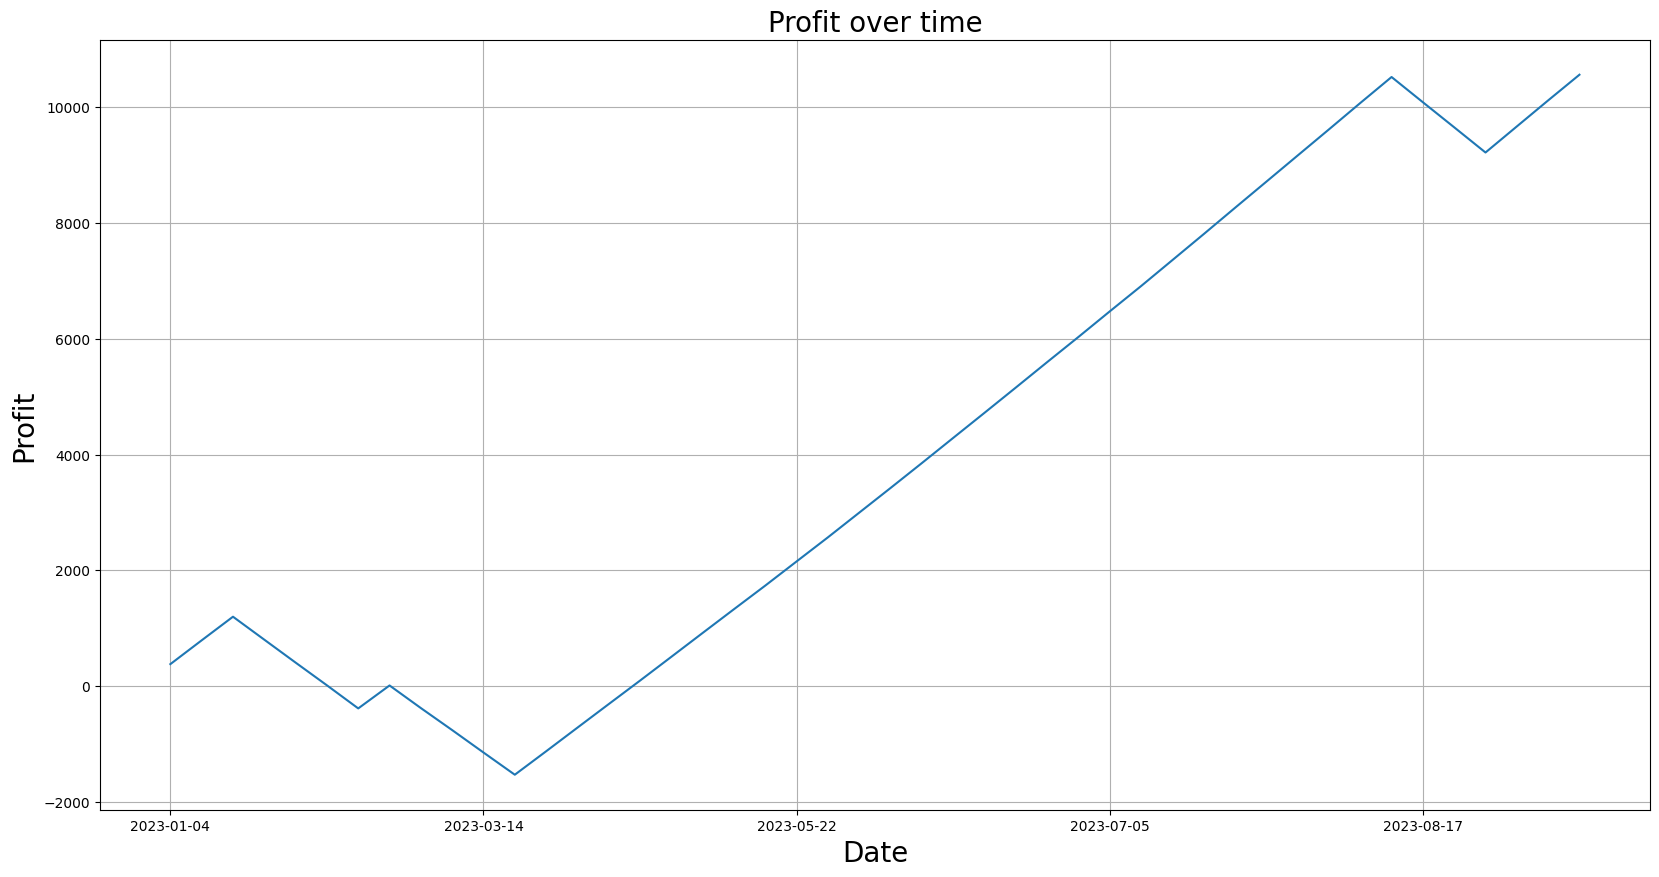

In [63]:
#plot profit over time
books.index = books['Date']
books['Profit'].plot(figsize=(20, 10))
plt.title('Profit over time', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Profit', fontsize=20)
plt.grid(axis='both')
plt.show()